________________
Polytech Nice Sophia 
## Nada Benchekroun 

# Détection de tumeurs avec un réseau de neurones en imagerie médicale
 
## Introduction

Dans le domaine de l'imagerie médicale, le prétraitement des images radiographiques est essentiel afin de détecter efficacement des tumeurs cancéreuses. Il s'agit également de localiser ces tumeurs et d'estimer leurs tailles. De cette manière, les médecins peuvent exploiter ces informations pour diagnostiquer la maladie mais aussi suivre l'évolution du traitement. 

Dans ce projet, nous chercherons à détecter des tumeurs cancéreuses dans le foie. Nous utiliserons des données en accès libre qui ont été annontées par des experts (radiologistes et oncologues): les tumeurs sont donc connues et localisées. La figure ci-après donne une idée des images qui seront utilisées.

![Original-Mask](intro.png)


Nous pouvons voir l'image originale et l'image "mask" qui représente les pixels associés au foie. Cette image "mask" représente l'annotation fournie par les spécialistes. Il convient de construire un algorithme qui permet de retrouver ce masque de manière automatique dans l'image origimale.

Dans le domaine du traitement d'images, les méthodes les plus efficaces actuelement s'appuient sur des réseaux de neurones profonds. Le but de ce projet est donc de développer un réseau de neurones profond pour détecter les tumeurs dans les images du foie. Nous utiliserons Python, et notamment l'environnement Pytorch dédié aux réseaux de neurones profonds, pour réaliser ce projet.

Nous nous sommes séparés en deux binômes pour bien démarrer le projet: une équipe "images" qui a pour but de bien comprendre la base de données fournie (le format des images, la visualisation des images, le prétraitement des images, la conversion, etc.), et une équipe "deep learning" qui est responsable de maîtriser les bases du Deep Learning afin de choisir le bon réseau de neuronnes pour nos images. 

## Base de données

La base de donnée contient 131 images radiographiques originales et leur images "masks" correspondants, soit 232 images au total, en format NII. 

### Fichiers NII

Les fichiers dont l'extension est .NII sont des fichiers de type "NIfTI-1 data format by Neuroimaging Informatics Technology Initiative", c'est donc un format de fichiers dédié à l'imagerie médicale.

Avant de passer au prétraitement des données et à la visualisation des images sous Python, nous avons préféré de concevoir une idée générale sur nos images radiographiques. Nous avons utilisé ITK-SNAP, c'est une application logicielle interactive qui permet aux utilisateurs de parcourir des images médicales, de délimiter manuellement les régions anatomiques d'intérêt et d'effectuer une segmentation automatique des images. 

Le logiciel est disponible gratuitement pour téléchargement dans le lien suivant: http://www.itksnap.org/pmwiki/pmwiki.php?n=Downloads.SNAP3 . Il suffit après d'ouvrir une des images originaux et d'y ajouter l'image mask pour visualiser l'ensemble :

![ITK-SNAP](logiciel.jpg)

Grâce à ce logiciel, nous avons pu comprendre la forme de nos images NII : les images radiographiques sont des images tridimensionnelles auxquelles on peut ajouter la segmentation correspondante pour parcourir l'ensemble en 3D. Sur l'image ci-dessus, la zone rouge correspond au foie, étiquetée par le "label" 1, et la zone en vert correspond à la tumeur, en "label" 2.

### Prétraitement des données

On va rassembler les 232 images dans un dataframe contenant pour chacune des 131 images originales son fichier source, son nom, le fichier source de son image "mask" et le nom de cette dernière:

* installation et importation des librairies nécessaires :

In [1]:
# !pip install torch
# !pip install --upgrade kornia
# !pip install allennlp==1.1.0.rc4
# !pip install --upgrade fastai
# !pip install nibabel
# !pip install opencv-python

In [2]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import glob

import nibabel as nib
import cv2
import imageio
from tqdm.notebook import tqdm
from ipywidgets import *
from PIL import Image
from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import *

* Création du dataframe contenant l'ensemble des images

In [3]:
file_list = []
for dirname, _, filenames in os.walk('LiTS'):
    for filename in filenames:
        file_list.append((dirname,filename)) 

for dirname, _, filenames in os.walk('LiTS-pt2'):
    for filename in filenames:
        file_list.append((dirname,filename)) 

df_files = pd.DataFrame(file_list, columns =['dirname', 'filename']) 
df_files.sort_values(by=['filename'], ascending=True)  

,dirname,filename
0,LiTS\segmentations,segmentation-0.nii
1,LiTS\segmentations,segmentation-1.nii
2,LiTS\segmentations,segmentation-10.nii
3,LiTS\segmentations,segmentation-100.nii
4,LiTS\segmentations,segmentation-101.nii
...,...,...
227,LiTS-pt2\volume_pt6,volume-95.nii
228,LiTS-pt2\volume_pt6,volume-96.nii
229,LiTS-pt2\volume_pt6,volume-97.nii
230,LiTS-pt2\volume_pt6,volume-98.nii


Maintenant, il faut associer à chaque image originale son image "mask". On ajoute donc deux nouvelles colonnes pour le chemin et vers les "masks" et leur nom, puis on les associe aux originaux:

In [4]:
df_files["mask_dirname"] = ""
df_files["mask_filename"] = ""

for i in range(131):
    ct = f"volume-{i}.nii"
    mask = f"segmentation-{i}.nii"
    
    df_files.loc[df_files['filename'] == ct, 'mask_filename'] = mask
    df_files.loc[df_files['filename'] == ct, 'mask_dirname'] = "LiTS/segmentations"

# On enlève les lignes sans masks, i.e. les masks
df_files = df_files[df_files.mask_filename != ''].sort_values(by=['filename']).reset_index(drop=True) 
print(len(df_files))
df_files

131


,dirname,filename,mask_dirname,mask_filename
0,LiTS\volume_pt1,volume-0.nii,LiTS/segmentations,segmentation-0.nii
1,LiTS\volume_pt1,volume-1.nii,LiTS/segmentations,segmentation-1.nii
2,LiTS\volume_pt1,volume-10.nii,LiTS/segmentations,segmentation-10.nii
3,LiTS-pt2\volume_pt6,volume-100.nii,LiTS/segmentations,segmentation-100.nii
4,LiTS-pt2\volume_pt8,volume-101.nii,LiTS/segmentations,segmentation-101.nii
...,...,...,...,...
126,LiTS-pt2\volume_pt6,volume-95.nii,LiTS/segmentations,segmentation-95.nii
127,LiTS-pt2\volume_pt6,volume-96.nii,LiTS/segmentations,segmentation-96.nii
128,LiTS-pt2\volume_pt6,volume-97.nii,LiTS/segmentations,segmentation-97.nii
129,LiTS-pt2\volume_pt6,volume-98.nii,LiTS/segmentations,segmentation-98.nii


## Visualisation des images radiographiques

Pour visualiser les images sous format NII, on va utiliser la librairie NiBabel. C'est une librairie qui fournit les droits d'accès en lecture/écriture sur quelques formats communs d'imagerie neurologique et médicale comme GIFTI, NIfTI1, NIfTI2, etc. 

Cet accès se fait via les NumPy arrays, la fonction suivante prend en argument le chemin vers une image NII et retourne une liste contenant les pixels de l'image:

In [5]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

Lisons donc quelques image radio et leur image "mask" et vérifions leurs dimensions:

In [6]:
sample = 0
sample_ct   = read_nii(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])
sample_mask  = read_nii(df_files.loc[sample,'mask_dirname']+"/"+df_files.loc[sample,'mask_filename'])
sample_ct.shape, sample_mask.shape

((512, 512, 75), (512, 512, 75))

In [7]:
sample = 7
sample_ct_7   = read_nii(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])
sample_mask_7  = read_nii(df_files.loc[sample,'mask_dirname']+"/"+df_files.loc[sample,'mask_filename'])
sample_ct_7.shape, sample_mask_7.shape

((512, 512, 781), (512, 512, 781))

In [8]:
sample = 70
sample_ct_70   = read_nii(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])
sample_mask_70  = read_nii(df_files.loc[sample,'mask_dirname']+"/"+df_files.loc[sample,'mask_filename'])
sample_ct_70.shape, sample_mask_70.shape

((512, 512, 119), (512, 512, 119))

Nos images radiographiques sont donc des images en 3 dimensions 512 x 512 x n, où n varie d'une image à une autre.

### Image 3D

Essayons maintenant de comprendre un peu plus la forme de ces images radiographiques, ce sont des images en 3 dimensions: 512 x 512 x n. 

Les valeurs que prennent les pixels de l'image originale et du "mask" varient comme suit:

In [9]:
print(f"pixels image originale: {np.amin(sample_ct_70)} -> {np.amax(sample_ct_70)}")
print(f"pixels image mask: {np.amin(sample_mask_70)} -> {np.amax(sample_mask_70)}")

pixels image originale: -1024.0 -> 1023.0
pixels image mask: 0.0 -> 2.0


Traçons des histogrammes pour voir la répartition de ces valeurs:

Text(0.5, 1.0, 'image mask')

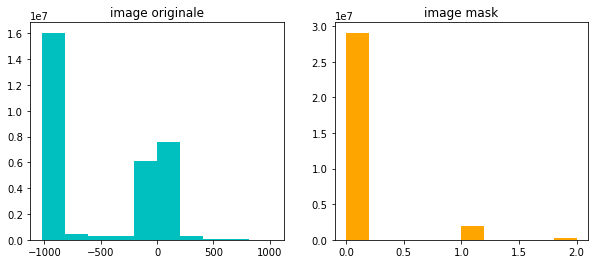

In [10]:
px_orig = sample_ct_70.flatten()
px_mask = sample_mask_70.flatten()

fig_1 = plt.figure(figsize=(10,4))
ax_1 = fig_1.add_subplot(1,2,1)
ax_1.hist(px_orig, color='c')
plt.title(f"image originale")

ax_2 = fig_1.add_subplot(1,2,2)
ax_2.hist(px_mask, color='orange')
plt.title(f"image mask")

#### Image originale

On remarque que pour l'image originale, les valeurs varient entre -1000 et 1000. En effet, les images DICOM (Digital imaging and communications in medicine) on comme unitée de mesure le Hounsfield (HU). c'est une échelle quantitative utilisée pour décrire la radio densité. Elle applique une transformation linéaire où la radiodensité de l'eau distillée à pression et température standards (STP) est définie comme 0 HU, et la radiodensité de l'air est fixée à -1000 HU (cf. figure).

![Hounsfield scale](scale.png)

*Pour plus de détails sur les images DICOM: https://towardsdatascience.com/a-matter-of-grayscale-understanding-dicom-windows-1b44344d92bd*

Pour certaines images radiographiques, on trouve des valeurs qui sortent de cet intervalle. Ce sont des valeurs aberrantes qui n'apparaissent que sur le contour de l'image radiographiques et la variation des pixels reste principalement entre -1000 et 1000 comme le montre le cas suivant:

In [11]:
print(f"pixels image originale: {np.amin(sample_ct_7)} -> {np.amax(sample_ct_7)}")

pixels image originale: -3088.0 -> 10856.0


Les pixels varient entre -3000 et 10000 pour la 8ème image radiographique, mais l'histogramme nous montre que la quasi-totalité de ces pixels sont toujours dans l'intervalle $[-1000,1000]$

Text(0.5, 1.0, 'image mask')

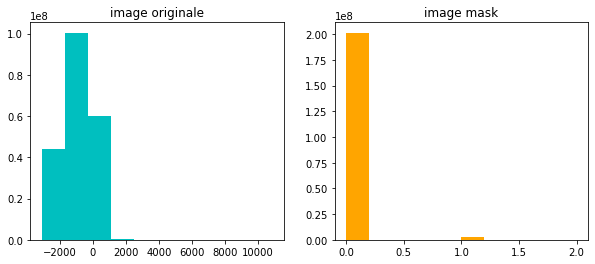

In [12]:
px_orig_7 = sample_ct_7.flatten()
px_mask_7 = sample_mask_7.flatten()

fig_2 = plt.figure(figsize=(10,4))
ax_1 = fig_2.add_subplot(1,2,1)
ax_1.hist(px_orig_7, color='c')
plt.title(f"image originale")

ax_2 = fig_2.add_subplot(1,2,2)
ax_2.hist(px_mask_7, color='orange')
plt.title(f"image mask")

On va afficher alors la première image dont les valeurs sont tous entre -1000 et 1000 et la comparer avec la deuxième où les valeurs aberrantes sont présentes: 

Text(0.5, 1.0, "l'image avec valeurs aberrantes")

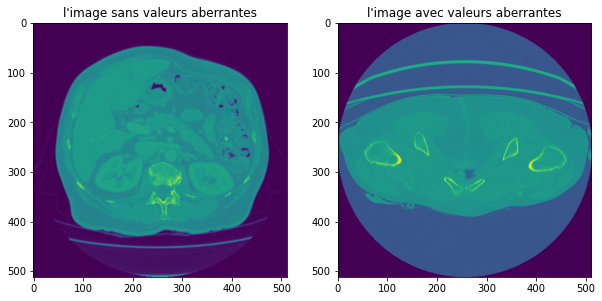

In [13]:
fig_3 = plt.figure(figsize=(10,7))

ax1 = fig_3.add_subplot(1,2,1)
plt.title(f"l'image sans valeurs aberrantes")
ax1.imshow(sample_ct_70[...,50])

ax2 = fig_3.add_subplot(1,2,2)
ax2.imshow(sample_ct_7[...,50])
plt.title(f"l'image avec valeurs aberrantes")

On voit que la principale différence entre la présence et l'absence des valeurs aberrantes est le contour, où la forme du cercle est plus claire lorsque ces valeurs sont présentes.

#### Image "mask"

Pour les images "masks", les pixels prennent les valeurs 0,1 ou 2. 0 étant le "label" ou bien l'étiquette de tout ce qui n'est pas foie, 1 celui du foie et 2 celui des tumeurs. Le dictionnaire suivant montre le nombre de pixels appartenant à chaque label: 

In [14]:
unique, counts = np.unique(sample_mask_70, return_counts=True)
count = dict(zip(unique, counts))
count

{0.0: 29088639, 1.0: 1920507, 2.0: 185990}

Étant des images 3D, le même principe que nous avons appliqué pour la vue inférieure (512x512) s'applique aux autres vues. Pour la vue de face (512 x n) par exemple:

In [15]:
print(sample_ct_70[0,...].shape)
print(sample_ct_7[0,...].shape)

(512, 119)
(512, 781)


Text(0.5, 1.0, "l'image avec valeurs aberrantes")

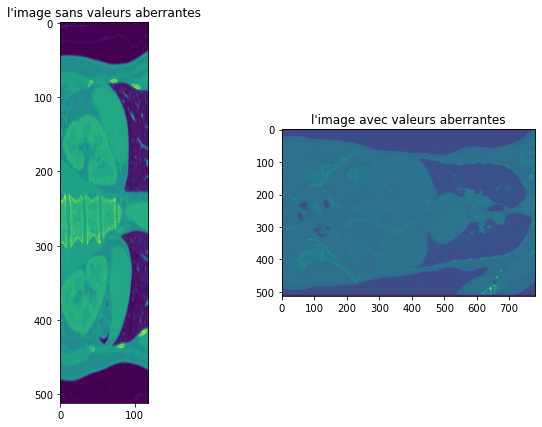

In [16]:
fig_4 = plt.figure(figsize=(10,7))
ax1 = fig_4.add_subplot(1,2,1)
plt.title(f"l'image sans valeurs aberrantes")
ax1.imshow(sample_ct_70[300,...])
ax2 = fig_4.add_subplot(1,2,2)
ax2.imshow(sample_ct_7[300,...])
plt.title(f"l'image avec valeurs aberrantes")

### Prétraitement des images NII

Les images DICOM contiennent des valeurs élevés de pixels et le "windowing" peut être considéré comme une manière de manipuler ces valeur afin de changer l'apparence des images pour que les structures particulières soient mises en évidence.

Les images DICOM contiennet typiquement des valeurs entre 12 et 16 bits par pixel, ce qui correspond approximativement à 4,096 à 65,536 nuances de gris. Cependant, la majorité des moniteurs utilisé sont souvent limités à 8 bits, ou bien 256 nuances de gris. 

Le principe du "windowing" est de concentrer les 256 nuances de gris dans un petit intervalle de l'unité Hounsfield qui contient les densités pertinentes des tissus dont on serait intéressé.

La librairie de l'imagerie médicale fastai fournit des gammes de "windows" qu'on peut utiliser avec la fonction windowed, qui peut être appelée en utilisant dicom_windows :

In [17]:
# Preprocess the nii file 
# Source https://docs.fast.ai/medical.imaging

dicom_windows = types.SimpleNamespace(
    brain=(80,40),
    subdural=(254,100),
    stroke=(8,32),
    brain_bone=(2800,600),
    brain_soft=(375,40),
    lungs=(1500,-600),
    mediastinum=(350,50),
    abdomen_soft=(400,50),
    liver=(150,30),
    spine_soft=(250,50),
    spine_bone=(1800,400),
    custom = (200,60)
)

@patch
def windowed(self:Tensor, w, l): # l is brightness, w is the contrast
    px = self.clone()
    px_min = l - w//2
    px_max = l + w//2
    px[px<px_min] = px_min
    px[px>px_max] = px_max
    return (px-px_min) / (px_max-px_min)

En appliquant ce prétraitement à une image NII, on peut la visualiser : 

Text(0.5, 1.0, 'Mask')

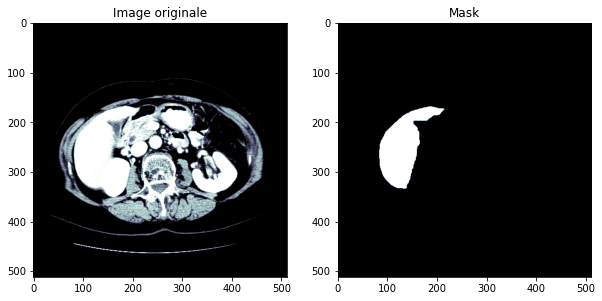

In [18]:
#Afficher les images radio et les masks 
fig_5 = plt.figure(figsize=(10,7))
ax1 = fig_5.add_subplot(1,2,1)
ax1.imshow(tensor(sample_ct[...,50].astype(np.float32)).windowed(*dicom_windows.liver), cmap=plt.cm.bone)
plt.title("Image originale")

ax2 = fig_5.add_subplot(1,2,2)
ax2.imshow(tensor(sample_mask[...,50].astype(np.float32)).windowed(*dicom_windows.liver), cmap=plt.cm.bone)
plt.title("Mask")

Pour expliquer comment fonctionne le "windowing", on va afficher une image avant et après prétraitement :

Text(0.5, 1.0, 'image après prétraitement')

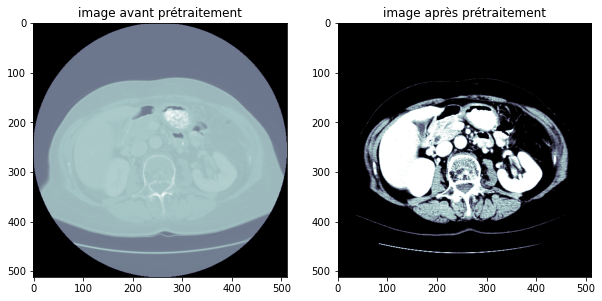

In [19]:
fig_5 = plt.figure(figsize=(10,7))
ax1 = fig_5.add_subplot(1,2,1)
ax1.imshow(sample_ct[...,50], cmap=plt.cm.bone)
plt.title("image avant prétraitement")

ax2 = fig_5.add_subplot(1,2,2)
ax2.imshow(tensor(sample_ct[...,50].astype(np.float32)).windowed(*dicom_windows.liver), cmap=plt.cm.bone)
plt.title("image après prétraitement")

Il est clair qu'il y a beaucoup plus de profondeur dans l'image après prétraitement. 

Cependant, cela peut être un problème lorsqu'on essaye de localiser des zones normales à celles qui ont été pathologiquement altérées. Mais dans la plupart des cas, la différence en unités Hounsfield entre les tissus normaux et pathologiquement altérés peut être très faible.

## Retour au prétraitement des données

### Étude des tumeurs

Après avoir pris connaissance de notre base de données, nous allons essayer d'améliorer notre dataframe. On va commencer par en ajouter deux colonnes: **mask_tumor** et **tumor_percentage%** qui représentent respectivement si l'image masque contient le label 2 correspondant aux tumeurs, et le pourcentage en volume (au sens de pixels) de cette tumeur par rapport au volume du foie. 

On va utliliser pour cela la fonction contains_tumor qui retourne ces deux valeurs :

In [20]:
def contains_tumor(mask):
    values, occurence = np.unique(mask, return_counts=True)
    count=dict(zip(values, occurence))
    try:
        k = occurence[2]
    except IndexError:
        k = 0
    return(k!=0) , (int(k)/int(count[1]))*100

Ajoutons maintenant ces valeurs à nos deux nouvelles colonnes avant de finalement visualiser notre dataframe :

In [21]:
df_files["mask_tumor"] = ""
df_files["tumor_percentage%"] = ""

for i in range(131):
    mask  = read_nii(df_files.loc[i,'mask_dirname']+"/"+df_files.loc[i,'mask_filename'])
    tumor=contains_tumor(mask)
    df_files.loc[i, 'mask_tumor'] = tumor[0]
    df_files.loc[i, 'tumor_percentage%'] = tumor[1]

df_files.head(10)

,dirname,filename,mask_dirname,mask_filename,mask_tumor,tumor_percentage%
0,LiTS\volume_pt1,volume-0.nii,LiTS/segmentations,segmentation-0.nii,True,0.47106
1,LiTS\volume_pt1,volume-1.nii,LiTS/segmentations,segmentation-1.nii,True,1.117464
2,LiTS\volume_pt1,volume-10.nii,LiTS/segmentations,segmentation-10.nii,True,0.850784
3,LiTS-pt2\volume_pt6,volume-100.nii,LiTS/segmentations,segmentation-100.nii,True,31.37451
4,LiTS-pt2\volume_pt8,volume-101.nii,LiTS/segmentations,segmentation-101.nii,True,5.838674
5,LiTS-pt2\volume_pt8,volume-102.nii,LiTS/segmentations,segmentation-102.nii,True,0.943519
6,LiTS-pt2\volume_pt8,volume-103.nii,LiTS/segmentations,segmentation-103.nii,True,3.191517
7,LiTS-pt2\volume_pt8,volume-104.nii,LiTS/segmentations,segmentation-104.nii,True,9.348003
8,LiTS-pt2\volume_pt8,volume-105.nii,LiTS/segmentations,segmentation-105.nii,False,0.0
9,LiTS-pt2\volume_pt8,volume-106.nii,LiTS/segmentations,segmentation-106.nii,False,0.0


### Conversion des images NII

Nous avons choisi d'utiliser le réseau de neuronnes U-Net, un réseau conçu et appliqué pour la première fois en 2015 par Oral Ronneberger pour la segmentation d’images médicales. Pour plus de détails sur la partie U-Net, veuillez voir le rapport rendu par l'équipe "deep".

U-Net prend en entrée des images de formats usuelles (jpg, png, etc.), il faut donc transformer nos images du format NII à l'une de ces formats. 

En plus d'avoir le bon format pour U-Net, avoir des images jpg ou png va être très utile vu que notre base de données est très volumineuse (49,9 Go), donc la manipulation  des images radiographiques sous le format NII prend beaucoup de temps et de mémoire. Dans cette optique, nous allons transformer les images 3D en format NII en images 2D de formats réguliers: **une image 3D de dimensions 512x512x n va être transformée en n images 512x512.**

Les images originaux seront transformées à des images en format jpg après les avoir prétraité grâce aux fonctions de la librairie fastai. Tant que pour les images "mask", nous allons utiliser le format png. Ce choix est dû au fait que les "labels" 1,2 et 3 que contient une image "mask" NII sont perdus si on transforme cette image en une image jpg, contrairement au format png qui conserve bien les "labels".

On commence donc par la définition des fonction de prétraitement de fastai :

In [22]:
# Preprocessing functions
# Source https://docs.fast.ai/medical.imaging

class TensorCTScan(TensorImageBW): _show_args = {'cmap':'bone'}

@patch
def freqhist_bins(self:Tensor, n_bins=100):
    "A function to split the range of pixel values into groups, such that each group has around the same number of pixels"
    imsd = self.view(-1).sort()[0]
    t = torch.cat([tensor([0.001]),
                   torch.arange(n_bins).float()/n_bins+(1/2/n_bins),
                   tensor([0.999])])
    t = (len(imsd)*t).long()
    return imsd[t].unique()

@patch
def hist_scaled(self:Tensor, brks=None):
    "Scales a tensor using `freqhist_bins` to values between 0 and 1"
    if self.device.type=='cuda': return self.hist_scaled_pt(brks)
    if brks is None: brks = self.freqhist_bins()
    ys = np.linspace(0., 1., len(brks))
    x = self.numpy().flatten()
    x = np.interp(x, brks.numpy(), ys)
    return tensor(x).reshape(self.shape).clamp(0.,1.)
    
    
@patch
def to_nchan(x:Tensor, wins, bins=None):
    res = [x.windowed(*win) for win in wins]
    if not isinstance(bins,int) or bins!=0: res.append(x.hist_scaled(bins).clamp(0,1))
    dim = [0,1][x.dim()==3]
    return TensorCTScan(torch.stack(res, dim=dim))

@patch
def save_jpg(x:(Tensor), path, wins, bins=None, quality=90):
    fn = Path(path).with_suffix('.jpg')
    x = (x.to_nchan(wins, bins)*255).byte()
    im = Image.fromarray(x.permute(1,2,0).numpy(), mode=['RGB','CMYK'][x.shape[0]==4])
    im.save(fn, quality=quality)

Dans le but de ne pas avoir une base de données très volumineuse, on ne va prendre que le tiers des fichiers NII pour la conversion:

In [31]:
# Make custom JPG files for Unet training
# Total number of 131 nii files contains 58638 slices 

GENERATE_JPG_FILES = False   # warning: generation takes ~ 1h

if (GENERATE_JPG_FILES) :
    
    path = Path(".")

    os.makedirs('train_images',exist_ok=True)
    os.makedirs('train_masks',exist_ok=True)

    for ii in tqdm(range(0,len(df_files),3)): # take 1/3 nii files for training
        curr_ct        = read_nii(df_files.loc[ii,'dirname']+"/"+df_files.loc[ii,'filename'])
        curr_mask      = read_nii(df_files.loc[ii,'mask_dirname']+"/"+df_files.loc[ii,'mask_filename'])
        curr_file_name = str(df_files.loc[ii,'filename']).split('.')[0]
        curr_dim       = curr_ct.shape[2] # 512, 512, curr_dim

        for curr_slice in range(0,curr_dim,2): # export every 2nd slice for training
            data = tensor(curr_ct[...,curr_slice].astype(np.float32))
            mask = Image.fromarray(curr_mask[...,curr_slice].astype('uint8'), mode="L")
            data.save_jpg(f"train_images/{curr_file_name}_slice_{curr_slice}.jpg", [dicom_windows.liver,dicom_windows.custom])
            mask.save(f"train_masks/{curr_file_name}_slice_{curr_slice}_mask.png")
else:
    
    path = Path("") # read jpg from saved kernel output

On va maintenant réunir ces images dans un nouveau dataframe:

In [32]:
bs = 16
im_size = 128

codes = np.array(["background","liver","tumor"])
    
def get_x(fname:Path): return fname
def label_func(x): return path/'train_masks'/f'{x.stem}_mask.png'

tfms = [IntToFloatTensor(),Normalize()]

db = DataBlock(blocks=(ImageBlock(),MaskBlock(codes)),  #codes = {"Backround": 0,"Liver": 1,"Tumor": 2}
               batch_tfms=tfms,
               splitter=RandomSplitter(),
               item_tfms=[Resize(im_size)],
               get_items=get_image_files,
               get_y=label_func
              )

ds = db.datasets(source=path/'train_images')
ds

(#10090) [(PILImage mode=RGB size=512x512, PILMask mode=L size=512x512),(PILImage mode=RGB size=512x512, PILMask mode=L size=512x512),(PILImage mode=RGB size=512x512, PILMask mode=L size=512x512),(PILImage mode=RGB size=512x512, PILMask mode=L size=512x512),(PILImage mode=RGB size=512x512, PILMask mode=L size=512x512),(PILImage mode=RGB size=512x512, PILMask mode=L size=512x512),(PILImage mode=RGB size=512x512, PILMask mode=L size=512x512),(PILImage mode=RGB size=512x512, PILMask mode=L size=512x512),(PILImage mode=RGB size=512x512, PILMask mode=L size=512x512),(PILImage mode=RGB size=512x512, PILMask mode=L size=512x512)...]

De cette manière on peux accéder à nos nouvelles images pour les visualiser:

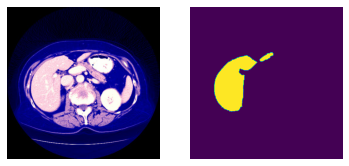

In [33]:
idx=25
imgs = [ds[idx][0],ds[idx][1]]
fig,axs = plt.subplots(1, 2)
for i,ax in enumerate(axs.flatten()):
    ax.axis('off')
    ax.imshow(imgs[i]) #, cmap='gray'

### Implémentation de U-Net

La partie d'inmplémentation, d'entraînement et de prédiction est détaillée dans le notebook 2 